In [1]:
import os
import numpy as np
# import working directory to check functions
os.chdir('/Users/schiend/Desktop/DOHERTY/R-workspace/cecelia/inst')

# config
import py.config_utils as cfg

%load_ext autoreload
%autoreload 2

In [2]:
base_dir = '/Volumes/Analysis_SSD/Dominik/cecelia/projects/wEsnzt/ANALYSIS/'
zero_dir = os.path.join(base_dir, '0/n22foC/')
#im_path = os.path.join(zero_dir, 'ccidImage.ome.zarr')
im_path = os.path.join(zero_dir, 'ccidRegistered.zarr')
version_num = 1
task_dir = os.path.join(base_dir, str(version_num), 'n22foC')

In [3]:
from py.napari_utils import NapariUtils

napari_utils = NapariUtils()
napari_utils.viewer = None
napari_utils.open_viewer()
napari_utils.task_dir = task_dir

Could not find Java JRE compatible with x86_64 architecture
napari.manifest -> 'skan' could not be imported: Could not find file 'napari.yaml' in module 'skan'


In [4]:
channel_names = [
    #'BCL2','CD10','Hoechst 33342','CD20','CD3','Collagen IV','CD23','BCL6','CD138','IgD','CD31','CD21','CD163','HLA-DR','CD11c','CD1c','CD25','FOXP3','CD8','CD69','PD-1','CD4','CD38','SPARC','CD68','IRF4','ICOS','Ki-67','CD35','CXCL13','TCR Va7.2','CD44','CD106','a-SMA','Lyve-1','DC-SIGN','CD45','CLEC9a AF488'
    'CD21','CD54','Hoechst','CD20','CD68','Glycophorin A','Fibrinogen','CD163','CD49a','CD138','CD15','HLA-DR','CD11c','Vimentin','CD4','CD31','Ki-67','CD3','CD8','SPARC','CD44','CD61','CD45','SMA','Lumican'
]

In [5]:
napari_utils.open_image(
    im_path,
    use_channel_axis = True, as_dask = True,
    visible = False, channel_names = channel_names
)

[1, 25, 9, 6543, 12977]


In [82]:
napari_utils.show_labels_all(
    show_labels = True,
    show_points = True,
    value_names = ['default']
)

{'base': '/Volumes/Analysis_SSD/Dominik/cecelia/projects/wEsnzt/ANALYSIS/1/n22foC/labels/default.zarr'}


In [55]:
napari_utils.show_labels_all(
    show_labels = True,
    show_points = False,
    value_names = ['stroma']
)

{'base': '/Volumes/Analysis_SSD/Dominik/cecelia/projects/wEsnzt/ANALYSIS/1/n22foC/labels/stroma.zarr'}


In [6]:
import py.zarr_utils as zarr_utils

In [57]:
# analyse stroma network
stroma_data, _ = zarr_utils.open_labels_as_zarr(
    '/Volumes/Analysis_SSD/Dominik/cecelia/projects/wEsnzt/ANALYSIS/1/n22foC/labels/stroma.zarr')

In [8]:
napari_utils.dim_utils.dim_idx('X', ignore_channel = True)

3

In [9]:
stroma_slices = [slice(None) for _ in range(len(stroma_data[0].shape))]
stroma_slices[napari_utils.dim_utils.dim_idx('X', ignore_channel = True)] = slice(100, 1100, 1)
stroma_slices[napari_utils.dim_utils.dim_idx('Y', ignore_channel = True)] = slice(100, 1100, 1)
stroma_slices = tuple(stroma_slices)

In [10]:
from skimage.morphology import skeletonize
import skan

In [62]:
binary_skeleton = skeletonize(
    (np.squeeze(stroma_data[0]) > 0).astype(np.uint8))
skeleton = skan.Skeleton(binary_skeleton)

In [63]:
all_paths = [
    skeleton.path_coordinates(i) for i in range(skeleton.n_paths)]

In [64]:
paths_table = skan.summarize(skeleton)

In [65]:
paths_table['path-id'] = np.arange(skeleton.n_paths)

In [66]:
paths_table['random-path-id'] = np.random.default_rng().permutation(skeleton.n_paths)

In [84]:
paths_table.to_csv('/Volumes/USER_data/Dominik/Experiments/IBEX/CECELIA/stroma/n22foC_branching.csv')

In [40]:
labels_layer = viewer.add_labels(
    np.squeeze(stroma_data[0][stroma_slices]),
    opacity = 1,
    name = 'stroma'
)

In [69]:
import skimage.morphology

In [67]:
skeleton_labels = skimage.morphology.dilation(np.asarray(skeleton), skimage.morphology.ball(1))

In [74]:
skeleton_layer = napari_utils.viewer.add_labels(
    np.expand_dims(skeleton_labels, axis = napari_utils.dim_utils.dim_idx('T')),
    properties = paths_table,
    opacity = 1,
    name = 'branching',
    scale = napari_utils.im_scale
)

In [86]:
# get branching distance
#percentile = 99.8
percentile = 100
chnl_scale = 255
#branching_values = paths_table['branch-distance'].values
branching_values = paths_table['branch-type'].values
label_ids = paths_table['path-id'].values

# get max value from intensity
max_chnl_val = np.percentile(branching_values, percentile)

# how to select a map.. ?
labels_cm = plt.cm.viridis(np.linspace(0, 1, num = chnl_scale))
# labels_cm = plt.cm.bwr(np.linspace(0, 1, num = chnl_scale))

# insert background
labels_cm = np.insert(labels_cm, 0, 0, axis = 0)

layer_chnl_colours = np.array(branching_values/max_chnl_val * chnl_scale - 1).astype(np.int)
layer_chnl_colours[layer_chnl_colours >= chnl_scale] = chnl_scale - 1
layer_chnl_colours[layer_chnl_colours <= 0] = 1
layer_chnl_colours = list(layer_chnl_colours)

# insert background
layer_chnl_colours.insert(0, 0)

# convert to dict
skeleton_layer.color = {x: labels_cm[layer_chnl_colours[i]] for i, x in enumerate(label_ids)}

/var/folders/rb/m9wptf8x58x_82t7lg081kfs1fj7kv/T/ipykernel_5041/4074366116.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  layer_chnl_colours = np.array(branching_values/max_chnl_val * chnl_scale - 1).astype(np.int)


In [79]:
import matplotlib.pyplot as plt

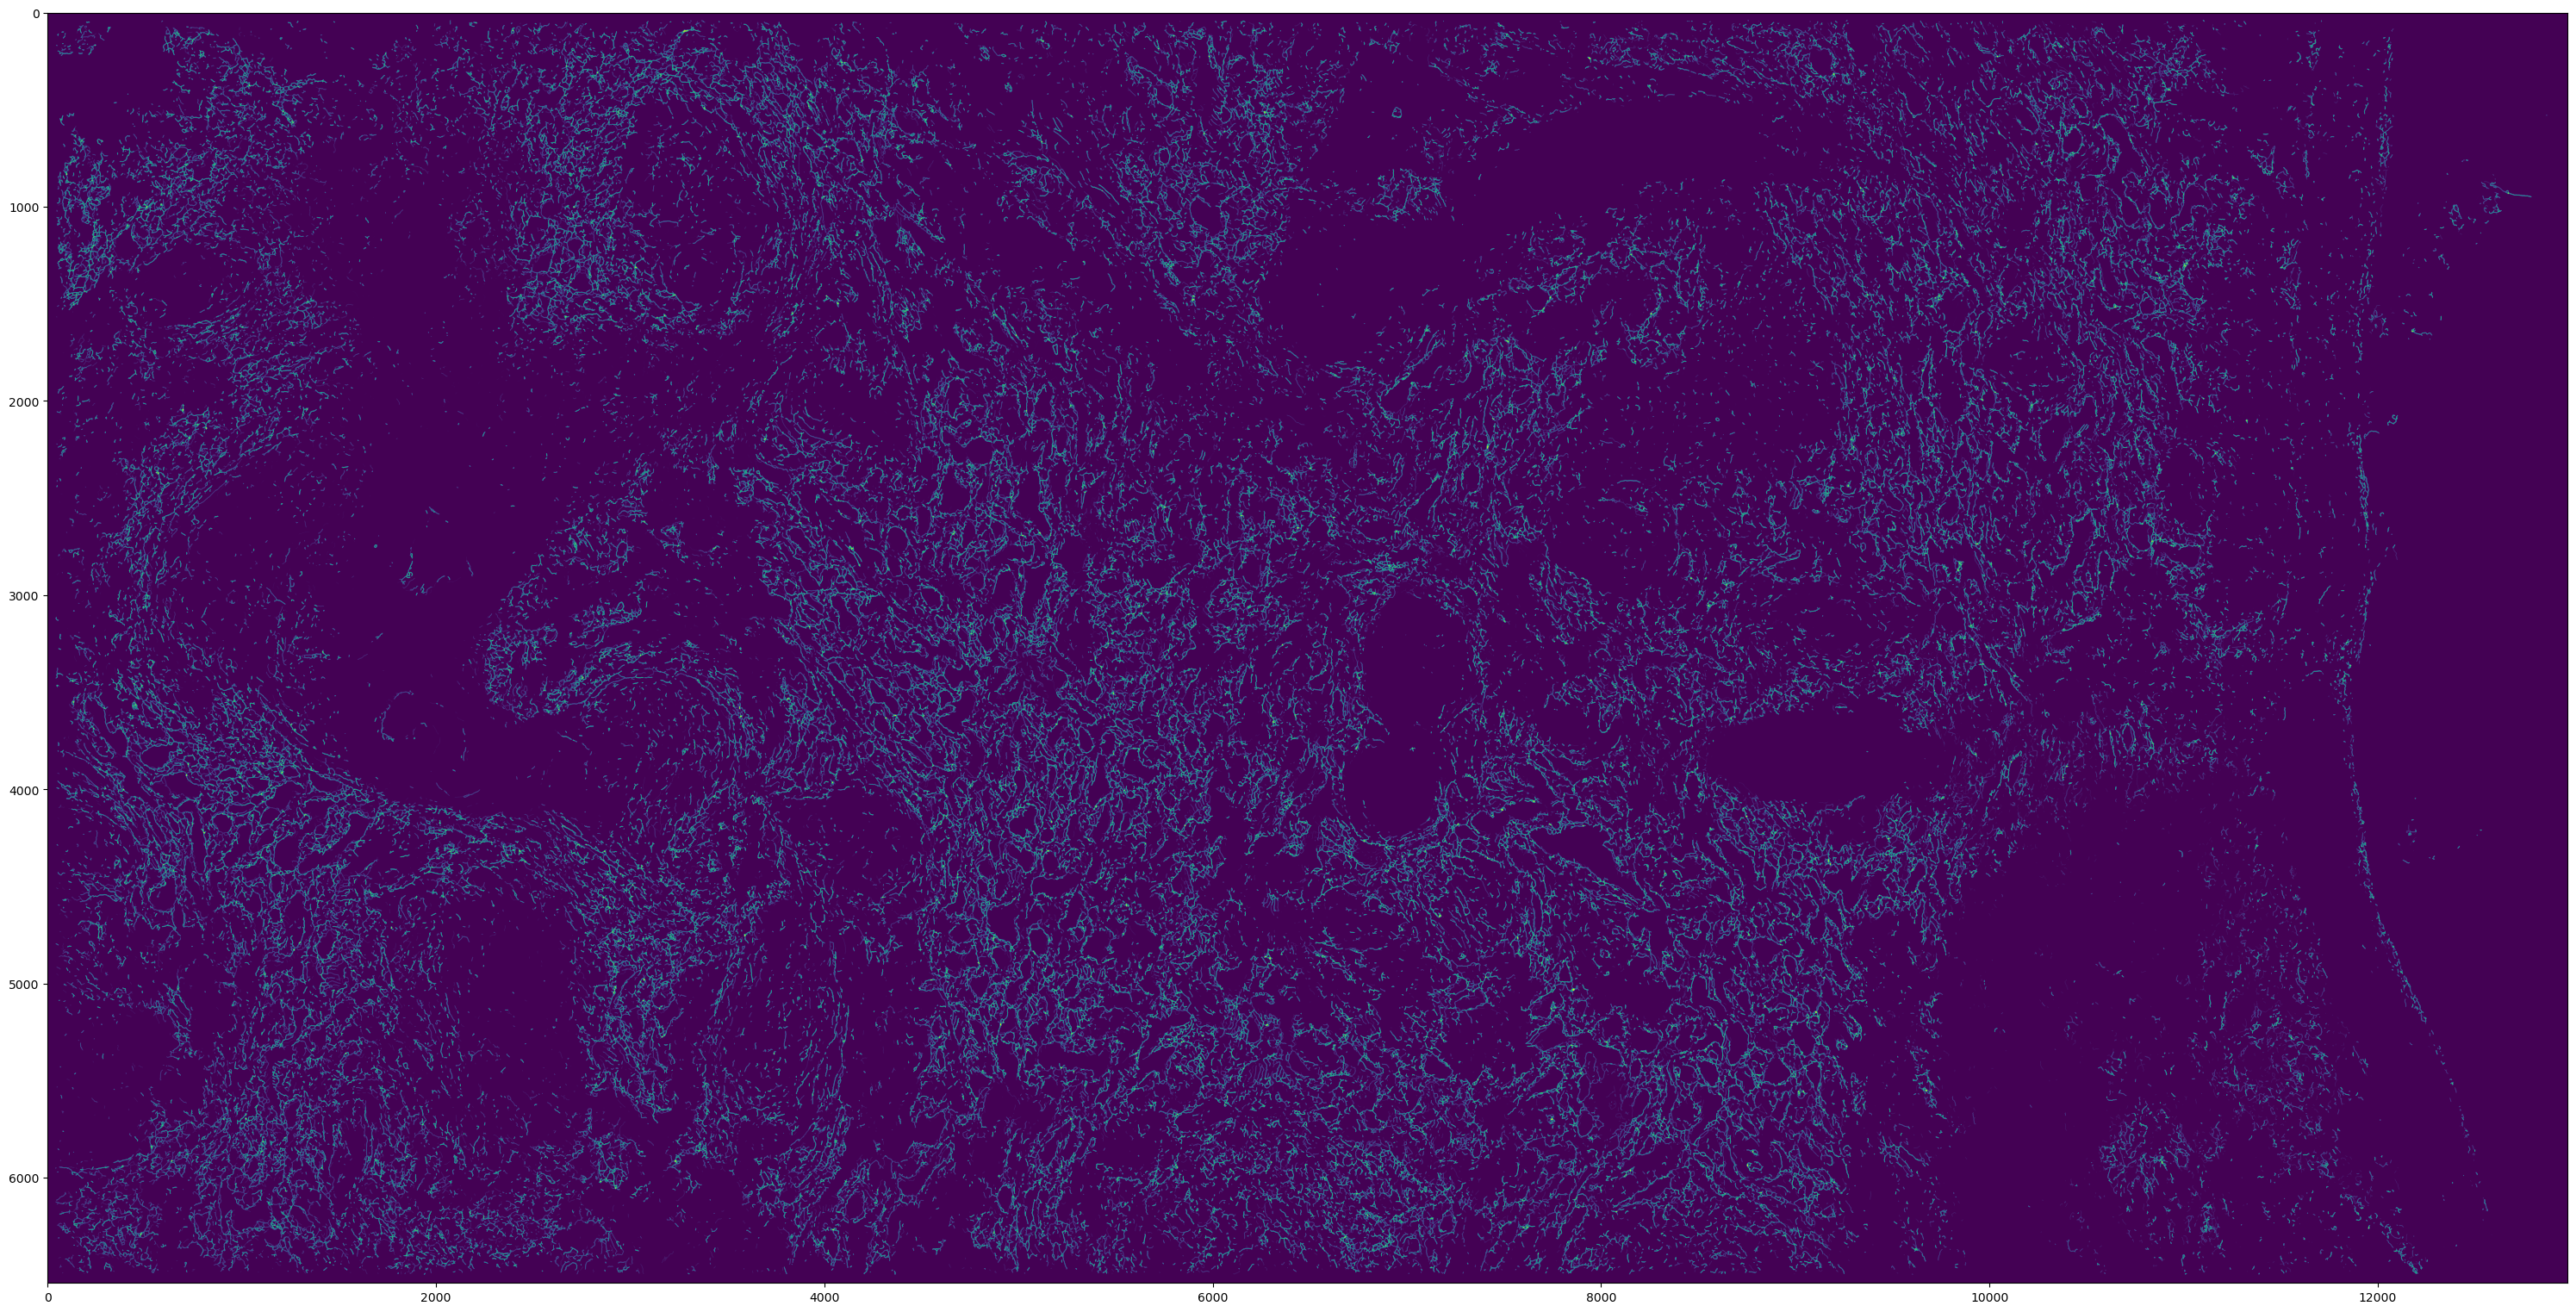

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 30))

axes.imshow(np.amax(skeleton_labels, axis = 0))

plt.tight_layout()
plt.show()